Import some libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import QlikSense_OEE
import os

# my modules
import set_config
from common_functions import create_df_from_file

import matplotlib.pyplot as plt
    


In [2]:
# call set_config
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_local = set_config.ConfigSectionMap("SectionOne")['local']

In [3]:
def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]


In [4]:
# read OEE Detailed Events report file for AL6 packaging machines
folder = 'IP21_data'

filename = 'AL6_Detailed_Losses_OEE.xlsx'
file = os.path.join(dir_sanofi_share, folder, filename)

df_OEE = pd.read_excel(file)
df_OEE['Date'] = df_OEE['Shift'].str[:5] + '/' + df_OEE['Shift'].str[12:16]
df_OEE['Date'] = pd.to_datetime(df_OEE['Date'], format='%d/%m/%Y')
df_OEE.rename(columns=({'Calendar Day':'Date', 
                        'Point of OEE (%)':'OEE',
                        'Loss Reason 3':'Category'}), inplace=True)
df_OEE['OEE'] = pd.to_numeric(df_OEE['OEE'], errors='coerce')
# df_OEE['OEE'] = df_OEE['OEE'].mul(100)
# df_OEE = df_OEE.set_index('Date')
df_OEE.shape

(1106, 4)

In [5]:
filename = 'AL6_Detailed_Losses_Mins.xlsx'
file = os.path.join(dir_sanofi_share, folder, filename)

df_MIN = pd.read_excel(file)
df_MIN['Date'] = df_MIN['Shift'].str[:5] + '/' + df_MIN['Shift'].str[12:16]
df_MIN['Date'] = pd.to_datetime(df_MIN['Date'], format='%d/%m/%Y')
df_MIN.rename(columns=({'Calendar Day':'Date', 
                        'Duration (d:hh:min)':'Duration',
                        'Loss Reason 3':'Category'}), inplace=True)
# df_MIN['OEE'] = pd.to_numeric(df_MIN['OEE'], errors='coerce')
# df_OEE['OEE'] = df_OEE['OEE'].mul(100)
# df_MIN = df_MIN.set_index('Date')
df_MIN.shape

(1106, 4)

In [6]:
df_MIN

Shift                                        Category  \
0     31/07 NACH (2021)                         Autonome Wartungen (24)   
1     31/07 NACH (2021)                                      Minor Loss   
2     31/07 NACH (2021)  Organisatorische Verluste und Wartezeiten (22)   
3     31/07 NACH (2021)               Störungen und Fehlerbehebung (25)   
4     02/08 SPAE (2021)                                      Minor Loss   
...                 ...                                             ...   
1101  28/10 FRUE (2021)                                      Minor Loss   
1102  28/10 FRUE (2021)  Organisatorische Verluste und Wartezeiten (22)   
1103  28/10 FRUE (2021)                               Rüstvorgänge (21)   
1104  28/10 FRUE (2021)               Störungen und Fehlerbehebung (25)   
1105  28/10 FRUE (2021)                                   Without cause   

      Duration       Date  
0     00:45:10 2021-07-31  
1     00:11:43 2021-07-31  
2     01:59:48 2021-07-31  
3     00:41:39 2021-07-31  
4     00:48:17 2021-08-02  
...        ...        ...  
1101  00:12:55 2021-10-28  
1102  01:02:44 2021-10-28  
1103  00:35:00 2021-10-28  
1104  03:21:52 2021-10-28  
1105  01:24:42 2021-10-28  

[1106 rows x 4 columns]

In [7]:
df = df_MIN.merge(df_OEE, on=['Date','Category','Shift'])

In [8]:
df = df.set_index('Date')

Let's translate these stoppage categories!

| German | English | 
| ------ | ------- |
|Qualifizierung/Validierung (11)|Qualification/validation|    
|Sonstiges und Unbekannte (26)|Other and unknown|   
|Störungen und Fehlerbehebung (25)|Malfunctions and troubleshooting|    
|W&I (geplante Linie) (23)|W&I (planned line)|   
|Organisatorische Verluste und Wartezeiten (22)|Organizational losses and waiting times|   
|Rüstvorgänge (21)|Changeover|    
|Ungeplante Linie (14)|Unplanned Line|   
|Feier/Brückentag (12)|Celebration / long day|   
|Autonome Wartungen (24)|Autonomous maintenance|   
|vorbeugende Instandhaltung/Wartung (13)|Preventive maintenance / servicing|   
|Sonstige (15)|Other|   



In [9]:
df['Category'].replace({
'Qualifizierung/Validierung (11)':'Qualification/validation', 
'Sonstiges und Unbekannte (26)':'Other and unknown',
'Störungen und Fehlerbehebung (25)':'Malfunctions and troubleshooting', 
'W&I (geplante Linie) (23)':'W&I (planned line)',
'Organisatorische Verluste und Wartezeiten (22)':'Organizational losses and waiting times',
'Rüstvorgänge (21)':'Changeover', 
'Ungeplante Linie (14)':'Unplanned Line',
'Feier/Brückentag (12)':'Celebration / long day', 
'Autonome Wartungen (24)':'Autonomous maintenance',
'vorbeugende Instandhaltung/Wartung (13)':'Preventive maintenance / servicing', 
'Sonstige (15)':'Other'}, inplace=True)


In [10]:
# just keep the 4 CHARs of Shift
df['Shift'] = df['Shift'].str[6:10]

In [11]:
# df['Month'] = df.index.strftime("%B")
# df['Day'] = df.index.strftime("%d")
# df.head()

# df_OEE.groupby(['Day', 'Month', 'Category'])[['OEE']].sum()

# df_OEE['Month'] = df_OEE['Month'].astype(pd.api.types.CategoricalDtype(categories=['August','September','October'], ordered=True))


# production = df_OEE[df_OEE.Category == ('Production')]
# changeover = df[df.Category == ('Changeover')]

# changeover_styled = changeover.pivot(index='Day', columns='Month', values='OEE').style.background_gradient(cmap='Oranges_r')\
# .format("{:.2f}")


# changeover_styled

In [12]:
category_order = ['Production',
'Organizational losses and waiting times', 
'Changeover', 
'Malfunctions and troubleshooting',
'Other and unknown', 
'Without cause', 
'Minor Loss', 
'Speed Loss', 
'Autonomous maintenance',
'Celebration / long day', 
'Other',
'Preventive maintenance / servicing', 
'Quality Loss',
'Unplanned Line',
'W&I (planned line)',
'Qualification/validation']

not using this one at the moment, as the categories are all over the place

In [13]:
# writer = pd.ExcelWriter(dir_sanofi_share + 'OEE data/AL6_OEE_Losses_pivot.xlsx', engine='xlsxwriter')
# for i in df_OEE.Month.unique():
#     pivot_OEE = df_OEE.pivot(index='Day', columns=['Category','Month'], values='OEE').filter(regex=i)
#     styler_OEE = pivot_OEE.style.background_gradient(cmap='Oranges')\
#         .background_gradient(subset=['Production'], cmap='Greens')\
#         # .format("{:,.2f}") # neither of these output to excel
#         # .set_precision(2)  # neither of these output to excel
    
#     styler_OEE.to_excel(writer, sheet_name=i)
#     # pivot_OEE.to_excel(writer, sheet_name=i)
#     workbook = writer.book
#     worksheet = writer.sheets[i]
#     # workbook = writer.book
#     # cell_format = workbook.add.format()
#     decimal = workbook.add_format({'num_format': '0.00'})
#     worksheet.set_column('A:Q', 20, decimal)
# #     call function get_col_widths to auto size the excel columns
#     # for x, width in enumerate(get_col_widths(pivot_OEE)):
#     #     #set each column width to be 1*25 that of the max string so that it fits nicely
#     #     worksheet.set_column(x, x, width * 1.25)    



# # workbook = writer.book
# # writer.save() # don't save until we've added more sheets below

This sorts the pivot by category, then month.

In [14]:
# writer = pd.ExcelWriter(dir_sanofi_share + 'AL6_OEE_Losses_pivot.xlsx', engine='xlsxwriter')

# pivot_sorted = df.pivot(index='Day', columns=['Category','Month'], values='OEE')
# pivot_sorted.columns = pivot_sorted.columns.set_levels(
#     pd.CategoricalIndex(
#         pivot_sorted.columns.levels[0],
#         ['Production',
#         'Organizational losses and waiting times', 
#         'Changeover', 
#         'Malfunctions and troubleshooting',
#         'Other and unknown', 
#         'Without cause', 
#         'Minor Loss', 
#         'Speed Loss', 
#         'Autonomous maintenance',
#         'W&I (planned line)',
#         'Celebration / long day', 
#         'Other',
#         'Preventive maintenance / servicing', 
#         'Quality Loss',
#         'Unplanned Line',
#         'Qualification/validation'],
#         ordered=True
#     ), level=0
# )

# pivot_sorted = pivot_sorted.sort_index(axis=1).style.background_gradient(cmap='Oranges')

# pivot_sorted.to_excel(writer)
# workbook = writer.book
# writer.save()

In [15]:
# pivot_OEE = df.pivot(index='Day', columns=['Category','Month'], values='OEE')
# pivot_OEE.stack().head(50)

In [22]:
df_qs_oee = QlikSense_OEE.qs_extract_oee()
df_qs_oee.reset_index(inplace=True)
df_qs_oee.rename(columns={'Calendar Day':'Date'}, inplace=True)
# bring units of OEE in line with all the other spreadsheets
df_qs_oee[['OEE %', 'Availability %', 'Performance %','AvailxPerf']] = df_qs_oee[['OEE %', 'Availability %', 'Performance %','AvailxPerf']] * 100
df_qs_oee

Date               Line             Shift Long Name  OEE %  \
0   2021-08-01  Devices Pens, AL6  FRUE - 01/08/2021 06:00:00    NaN   
1   2021-08-01  Devices Pens, AL6  NACH - 01/08/2021 22:00:00    NaN   
2   2021-08-01  Devices Pens, AL6  NACH - 31/07/2021 22:00:00   35.0   
3   2021-08-01  Devices Pens, AL6  SPAE - 01/08/2021 14:00:00    NaN   
4   2021-08-02  Devices Pens, AL6  FRUE - 02/08/2021 06:00:00    NaN   
..         ...                ...                         ...    ...   
345 2021-10-26  Devices Pens, AL6  NACH - 25/10/2021 22:00:00   47.0   
346 2021-10-26  Devices Pens, AL6  NACH - 26/10/2021 22:00:00   54.0   
347 2021-10-26  Devices Pens, AL6  SPAE - 26/10/2021 14:00:00   55.0   
348 2021-10-27  Devices Pens, AL6  FRUE - 27/10/2021 06:00:00   44.0   
349 2021-10-27  Devices Pens, AL6  NACH - 26/10/2021 22:00:00   30.0   

     Availability %  Performance % Quality %  Net Opening Time  \
0               NaN            NaN         -          0.000000   
1               NaN            NaN         -          0.000000   
2              43.0           83.0         1          6.000000   
3               NaN            NaN         -          0.000000   
4               NaN            NaN         -          0.000000   
..              ...            ...       ...               ...   
345            64.0           74.0         1          6.000000   
346            76.0           70.0         1          2.000000   
347            75.0           73.0         1          8.000000   
348            73.0           61.0         1          5.433611   
349            44.0           68.0         1          6.000000   

     Quantity (Pack)  Scheduled Down Total Potential Time      Useful Time  \
0                NaN             8.0             08:00:00         00:00:00   
1                NaN             2.0             02:00:00         00:00:00   
2            19152.0             0.0             06:00:00  02:07:40.800000   
3                NaN             8.0             08:00:00         00:00:00   
4                NaN             8.0             08:00:00         00:00:00   
..               ...             ...                  ...              ...   
345          16973.0             0.0             06:00:00  02:49:43.800000   
346           9664.0             0.0             02:00:00  01:04:25.600000   
347          39561.0             0.0             08:00:00  04:23:44.400000   
348          21700.0             0.0             05:26:01         02:24:40   
349          16145.0             0.0             06:00:00         01:47:38   

    Operating Time         Net Time  Duration (min) Frequency (stop./day)  \
0         00:00:00         00:00:00        0.000000                     -   
1         00:00:00         00:00:00        0.000000                     -   
2         02:33:23  02:07:40.800000      206.616667                   104   
3         00:00:00         00:00:00        0.000000                     -   
4         00:00:00         00:00:00        0.000000                     -   
..             ...              ...             ...                   ...   
345       03:48:39  02:49:43.800000      131.350000                   232   
346       01:31:27  01:04:25.600000       28.550000                   264   
347       06:01:57  04:23:44.400000      118.050000                   258   
348       03:59:07         02:24:40       86.900000               189.929   
349       02:37:31         01:47:38      202.483333                   160   

     AvailxPerf Shift  
0           NaN  FRUE  
1           NaN  NACH  
2          35.0  NACH  
3           NaN  SPAE  
4           NaN  FRUE  
..          ...   ...  
345        47.0  NACH  
346        54.0  NACH  
347        55.0  SPAE  
348        44.0  FRUE  
349        30.0  NACH  

[350 rows x 18 columns]

In [27]:
df_designation = create_df_from_file(dir_sanofi_share, 'IP21_Data', 'DESIGNATION')
df_designation

Name         IP_TREND_TIME   IP_TREND_VALUE  \
0   36650901_DESIGNATION  18-AUG-21 21:24:56.5    FS 5er Toujeo   
1   36650901_DESIGNATION  18-AUG-21 21:19:48.4    FS 5er Toujeo   
2   36650901_DESIGNATION  18-AUG-21 12:07:27.9    FS 5er Toujeo   
3   36650901_DESIGNATION  18-AUG-21 12:05:54.5              NaN   
4   36650901_DESIGNATION  18-AUG-21 11:56:23.4      FS 5er Solo   
..                   ...                   ...              ...   
43  36650901_DESIGNATION  06-SEP-21 23:16:32.5  Umstellprogramm   
44  36650901_DESIGNATION  06-SEP-21 23:15:24.6              NaN   
45  36650901_DESIGNATION  05-SEP-21 02:10:07.2    FS 3er Toujeo   
46  36650901_DESIGNATION  05-SEP-21 02:01:04.5    FS 3er Toujeo   
47  36650901_DESIGNATION  02-SEP-21 09:33:44.2    FS 3er Toujeo   

   IP_TREND_QLEVEL IP_TREND_QSTATUS  
0             Good             Good  
1              Bad              Bad  
2             Good             Good  
3             Good             Good  
4             Good             Good  
..             ...              ...  
43            Good             Good  
44            Good             Good  
45            Good             Good  
46             Bad              Bad  
47            Good             Good  

[72 rows x 5 columns]

In [17]:
# drop the line and Shift Long Name as don't have it in both dataframes
df_qs_oee.drop(columns=['Line','Shift Long Name'], inplace=True)


In [18]:
df_qs_oee['Operating Time'] = pd.to_datetime(df_qs_oee['Operating Time'], format='%H:%M:%S')
df_qs_oee['Net Time'] = pd.to_datetime(df_qs_oee['Net Time'], format='%H:%M:%S', exact=False)
df_qs_oee['Total Potential Time'] = pd.to_datetime(df_qs_oee['Total Potential Time'], format='%H:%M:%S', exact=False)

df_qs_oee['Operating Time'] = df_qs_oee['Operating Time'] - datetime.datetime(1900, 1, 1)
df_qs_oee['Net Time'] = df_qs_oee['Net Time'] - datetime.datetime(1900, 1, 1)
df_qs_oee['Total Potential Time'] = df_qs_oee['Total Potential Time'] - datetime.datetime(1900, 1, 1)

In [19]:
df_qs_oee.set_index('Date', inplace=True)

In [20]:
# this resolves the 2 NACH shifts, but all the calculated OEE% values are potentially wrong
grouped_oee = df_qs_oee.groupby([pd.Grouper(freq='D'), 'Shift']).sum().reset_index()
grouped_oee

Date Shift  OEE %  Availability %  Performance %  Net Opening Time  \
0   2021-08-01  FRUE    0.0             0.0            0.0          0.000000   
1   2021-08-01  NACH   35.0            43.0           83.0          6.000000   
2   2021-08-01  SPAE    0.0             0.0            0.0          0.000000   
3   2021-08-02  FRUE    0.0             0.0            0.0          0.000000   
4   2021-08-02  NACH    6.0             8.0           68.0          2.000000   
..         ...   ...    ...             ...            ...               ...   
259 2021-10-26  NACH  101.0           140.0          144.0          8.000000   
260 2021-10-26  SPAE   55.0            75.0           73.0          8.000000   
261 2021-10-27  FRUE   44.0            73.0           61.0          5.433611   
262 2021-10-27  NACH   30.0            44.0           68.0          6.000000   
263 2021-10-27  SPAE    NaN             NaN            NaN               NaN   

     Quantity (Pack)  Scheduled Down  Duration (min)  AvailxPerf  
0                0.0             8.0        0.000000         0.0  
1            19152.0             2.0      206.616667        35.0  
2                0.0             8.0        0.000000         0.0  
3                0.0             8.0        0.000000         0.0  
4             1022.0             6.0      110.050000         6.0  
..               ...             ...             ...         ...  
259          26637.0             0.0      159.900000       101.0  
260          39561.0             0.0      118.050000        55.0  
261          21700.0             0.0       86.900000        44.0  
262          16145.0             0.0      202.483333        30.0  
263              NaN             NaN             NaN         NaN  

[264 rows x 10 columns]

In [88]:
df_qs_oee.loc['2021-08-01']['Quantity (Pack)'] / df_qs_oee.loc['2021-08-01']['Operating Time'].dt.total_seconds() * 60


In [87]:
# df['Duration'] = pd.to_datetime(df['Duration'], format='%H:%M:%S')
df['Duration'] = df['Duration'] - datetime.datetime(1900, 1, 1)

In [453]:
# create categories as columns
pivot_Duration = df.reset_index().pivot(index=['Date','Shift'], columns='Category', values='Duration')
pivot_OEE = df.reset_index().pivot(index=['Date','Shift'], columns='Category', values='OEE')
# df

In [454]:
# merge pivot_OEE with QlikSense KPI values 
df_qs_oee_full = df_qs_oee.merge(pivot_OEE.reset_index(), on=['Date','Shift'])

In [461]:
folder = 'IP21_Data'
filename = 'AL6_OEE_full.xlsx'
path = os.path.join(dir_sanofi_share, folder, filename)
# writer = pd.ExcelWriter(path, engine='xlsxwriter')
df_qs_oee_full.to_excel(path, index=False)
# writer.save()

In [84]:
df.groupby(['Category'])['Duration'].sum().sort_values(ascending=True).plot.barh()

TypeError: unsupported operand type(s) for +: 'datetime.time' and 'datetime.time'

In [469]:
df_qs_oee_full.set_index('Date', inplace=True)

In [497]:
df_qs_oee_full.columns

Index(['OEE %', 'Availability %', 'Performance %', 'Quality %',
       'Net Opening Time', 'Quantity (Pack)', 'Scheduled Down',
       'Total Potential Time', 'Useful Time', 'Operating Time', 'Net Time',
       'Duration (min)', 'Frequency (stop./day)', 'AvailxPerf', 'Shift',
       'Autonomous maintenance', 'Changeover',
       'Malfunctions and troubleshooting', 'Minor Loss',
       'Organizational losses and waiting times', 'Other and unknown',
       'W&I (planned line)', 'Without cause'],
      dtype='object')

TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]

In [526]:

time_cols = ['Operating Time','Net Time']
df_qs_oee_full[['Shift','Quantity (Pack)','Operating Time','Net Time']].groupby([pd.Grouper(freq='D'),'Shift']).sum()


Quantity (Pack)
Date       Shift                 
2021-08-02 NACH          1022.000
           SPAE         25837.000
2021-08-03 FRUE         34438.000
           NACH         27912.000
           SPAE         26023.071
...                           ...
2021-10-26 FRUE          8899.000
           NACH         26637.000
           SPAE         39561.000
2021-10-27 FRUE         21700.000
           NACH         16145.000

[220 rows x 1 columns]

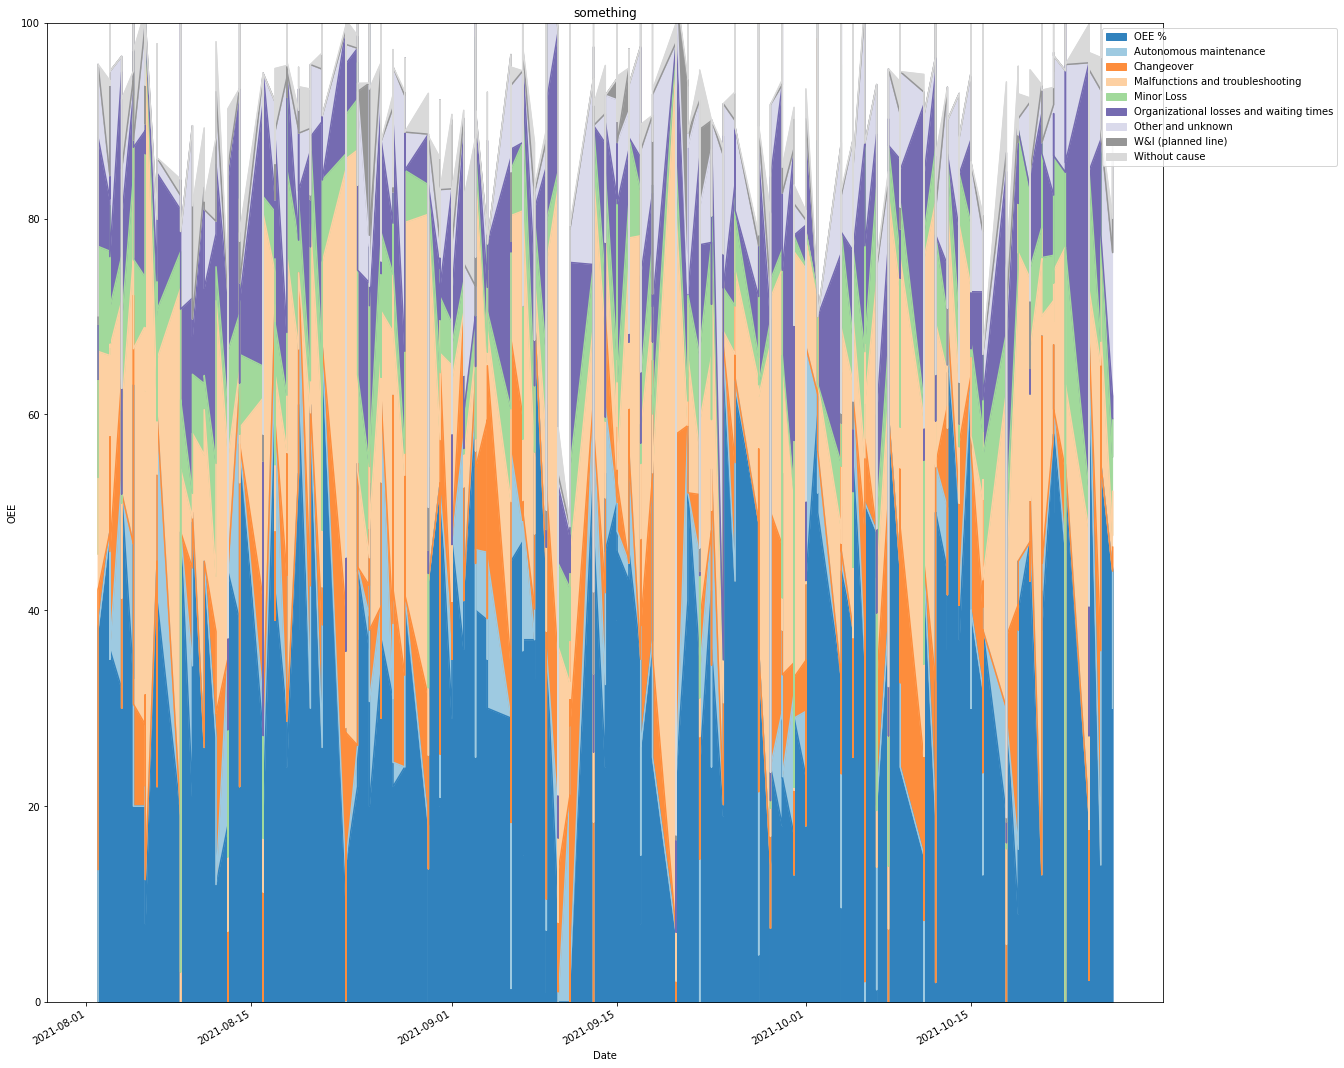

In [485]:
freq='D'

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

cols = ['OEE %','Autonomous maintenance', 'Changeover',
       'Malfunctions and troubleshooting', 'Minor Loss',
       'Organizational losses and waiting times', 'Other and unknown',
       'W&I (planned line)', 'Without cause']

data = df_qs_oee_full.groupby([pd.Grouper(freq=freq)]).sum()


# group[group.Machine == x].hist(label=('{}'.format(x)), ax=axs[i])
df_qs_oee_full[cols].plot.area(ax=ax, cmap='tab20c')
ax.set_title('something')
ax.set_ylabel('OEE')
ax.set_ylim(0,100)
ax.legend(loc='upper right', bbox_to_anchor=(1.16, 1.0))


In [459]:
# df_qs_oee_full['Changeover'].groupby([pd.Grouper(freq='D'), 'Shift']).mean()
df_qs_oee_full

Date  OEE %  Availability %  Performance % Quality %  \
0   2021-08-02    NaN             NaN            NaN         -   
1   2021-08-02    6.0             8.0           68.0       NaN   
2   2021-08-02   38.0            53.0           72.0         1   
3   2021-08-03   48.0            65.0           74.0         1   
4   2021-08-03   35.0            48.0           74.0         1   
..         ...    ...             ...            ...       ...   
286 2021-10-26   47.0            64.0           74.0         1   
287 2021-10-26   54.0            76.0           70.0         1   
288 2021-10-26   55.0            75.0           73.0         1   
289 2021-10-27   44.0            73.0           61.0         1   
290 2021-10-27   30.0            44.0           68.0         1   

     Net Opening Time  Quantity (Pack)  Scheduled Down Total Potential Time  \
0            0.000000              NaN             6.0             06:00:00   
1            2.000000           1022.0             0.0             02:00:00   
2            7.500000          25837.0             0.5             08:00:00   
3            8.000000          34438.0             0.0             08:00:00   
4            6.000000          19103.0             0.0             06:00:00   
..                ...              ...             ...                  ...   
286          6.000000          16973.0             0.0             06:00:00   
287          2.000000           9664.0             0.0             02:00:00   
288          8.000000          39561.0             0.0             08:00:00   
289          5.433611          21700.0             0.0             05:26:01   
290          6.000000          16145.0             0.0             06:00:00   

         Useful Time  ... AvailxPerf Shift  Autonomous maintenance Changeover  \
0           00:00:00  ...        NaN  NACH                     NaN  13.541667   
1    00:06:48.800000  ...        6.0  NACH                     NaN  13.541667   
2    02:52:14.800000  ...       38.0  SPAE                     NaN   4.092593   
3    03:49:35.200000  ...       48.0  FRUE                     NaN        NaN   
4    02:07:21.200000  ...       35.0  NACH                     NaN  12.500000   
..               ...  ...        ...   ...                     ...        ...   
286  02:49:43.800000  ...       47.0  NACH                14.03125        NaN   
287  01:04:25.600000  ...       54.0  NACH                14.03125        NaN   
288  04:23:44.400000  ...       55.0  SPAE                     NaN        NaN   
289         02:24:40  ...       44.0  FRUE                     NaN        NaN   
290         01:47:38  ...       30.0  NACH                     NaN  16.458333   

     Malfunctions and troubleshooting Minor Loss  \
0                           32.194444   7.850694   
1                           32.194444   7.850694   
2                           24.348148  10.729630   
3                           18.027778  10.652778   
4                           10.361111   9.451389   
..                                ...        ...   
286                         17.097222   6.850694   
287                         17.097222   6.850694   
288                         13.784722   9.586806   
289                          3.642361   8.010417   
290                          5.697917   7.430556   

     Organizational losses and waiting times  Other and unknown  \
0                                  10.010417           5.618056   
1                                  10.010417           5.618056   
2                                  11.125926           7.455556   
3                                   5.364583           2.347222   
4                                  14.527778          11.770833   
..                                       ...                ...   
286                                      NaN          17.003472   
287                                      NaN          17.003472   
288                                      NaN          10.222222   


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

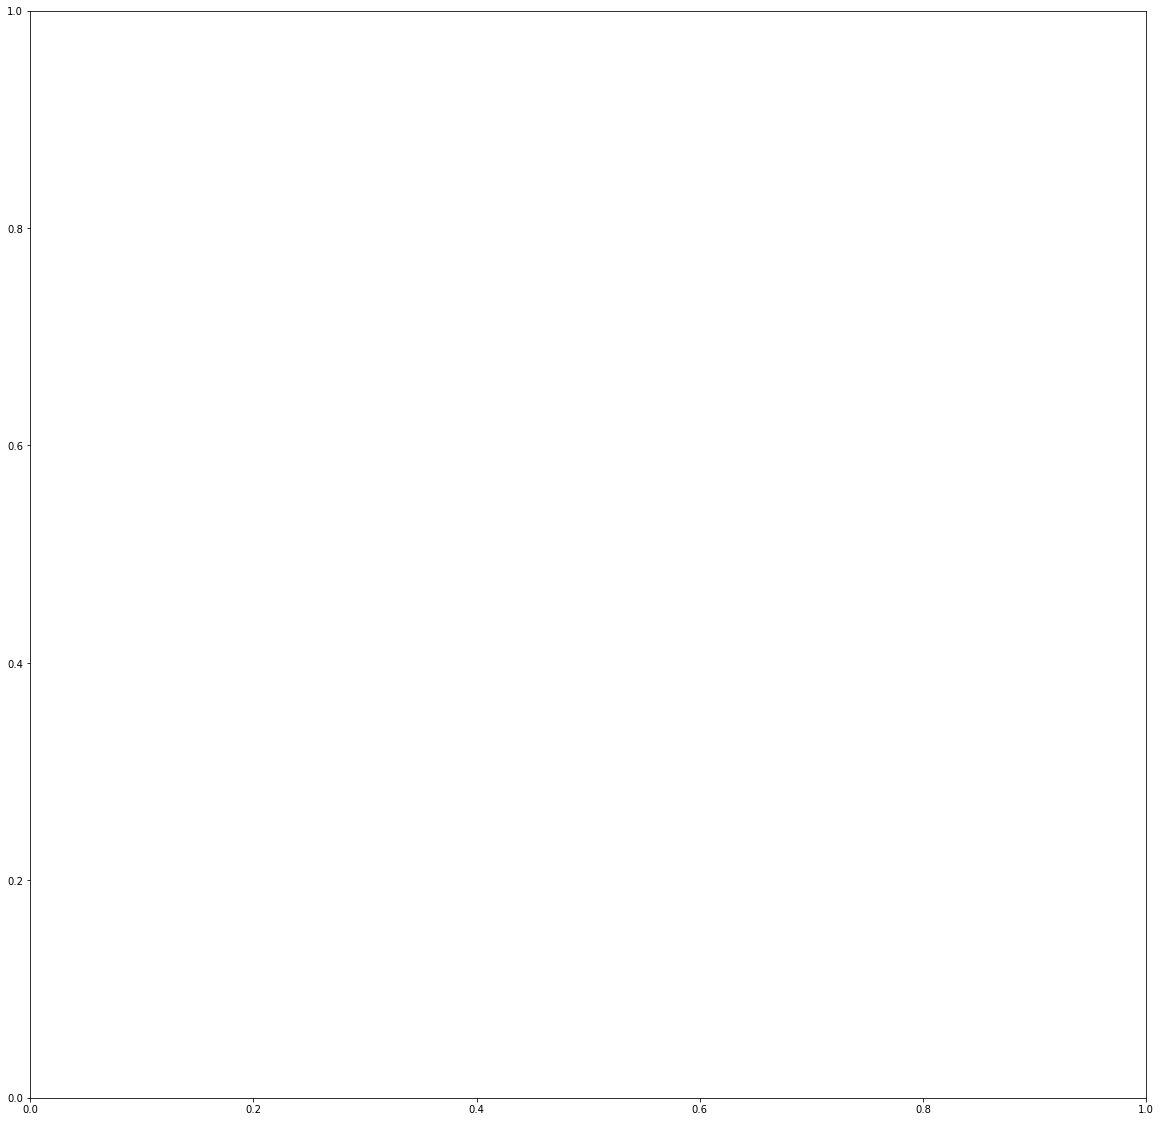

In [347]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# df_qs_oee_full.set_index('Date', inplace=True)
chart = df_qs_oee_full[['OEE %','Availability %','Performance %']].groupby([pd.Grouper(freq='D'), 'OEE %','Availability %','Performance %']).sum().reset_index()
chart.set_index('Date', inplace=True)

chart.plot(ax=ax)
# chart['Changeover'].plot.bar(ax=ax)
ax.set_ylim(0,1)



In [319]:
df_qs_oee_full[df_qs_oee_full['Performance %'] > 1]

OEE %  Availability %  Performance % Quality %  Net Opening Time  \
Date                                                                           
2021-08-23   0.38            0.38           1.01         1               2.0   
2021-09-09   0.36            0.29           1.26         1               8.0   
2021-09-23   0.24            0.13           1.92         1               2.0   
2021-10-02   0.88            0.03          33.43         1               2.0   

            Quantity (Pack)  Scheduled Down Total Potential Time  \
Date                                                               
2021-08-23           6842.0             0.0             02:00:00   
2021-09-09          17216.0             0.0             08:00:00   
2021-09-23           1299.0             0.0             02:00:00   
2021-10-02          10587.0             0.0             02:00:00   

                Useful Time Operating Time  ... AvailxPerf  Shift  \
Date                                        ...                     
2021-08-23  00:45:36.800000       00:45:15  ...       0.38   NACH   
2021-09-09  02:52:09.600000       02:17:04  ...       0.36   SPAE   
2021-09-23  00:29:02.400000       00:15:08  ...       0.24   NACH   
2021-10-02  01:45:52.200000       00:03:10  ...       0.88   NACH   

           Autonomous maintenance  Changeover  \
Date                                            
2021-08-23                    NaN    0.142361   
2021-09-09                    NaN   16.666667   
2021-09-23                    NaN   10.416667   
2021-10-02                    NaN   10.416667   

           Malfunctions and troubleshooting  Minor Loss  \
Date                                                      
2021-08-23                        27.892361    7.795139   
2021-09-09                        22.694444    4.312500   
2021-09-23                        15.795139    9.277778   
2021-10-02                        16.177083    4.128472   

            Organizational losses and waiting times  Other and unknown  \
Date                                                                     
2021-08-23                                      NaN           9.621528   
2021-09-09                                12.166667          19.916667   
2021-09-23                                11.760417           9.045139   
2021-10-02                                23.256944           6.177083   

            W&I (planned line)  Without cause  
Date                                           
2021-08-23                 NaN            NaN  
2021-09-09                 NaN            NaN  
2021-09-23                 NaN            NaN  
2021-10-02                 NaN          1.375  

[4 rows x 23 columns]

In [339]:
# df_qs_oee_full['Operating Time'] = pd.to_datetime(df_qs_oee_full['Operating Time'], format='%H:%M:%S')
# df_qs_oee_full['Operating Time'] = df_qs_oee_full['Operating Time'] - datetime.datetime(1900, 1, 1)
df_qs_oee_full.timestamp()

AttributeError: 'DataFrame' object has no attribute 'timestamp'

In [80]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_grouped = df.groupby([pd.Grouper(freq='D'), 'Machine'])['Duration (min.)'].mean().reset_index()
pivot = df_grouped.pivot(index='Start Date', columns='Machine', values='Duration (min.)')
pivot.fillna(0, inplace=True)
pivot['Total Duration'] = pivot.sum(axis=1)
styler_pivot = pivot.style.background_gradient(cmap='Purples')
styler_pivot.to_excel(writer, sheet_name='Detailed_Events (mins)')
worksheet = writer.sheets['Detailed_Events (mins)']
# workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

# workbook = writer.book
# workbook.add_format()
workbook.add_format({'num_format': '0.00'})
# writer.save()


KeyError: 'Machine'

In [60]:
df.loc['2021-05-01'].groupby(['Machine','Stoppage Reason 3','Last Level Reason']).mean().sort_values('Duration (min.)', ascending=False)

Duration (min.)
Machine           Stoppage Reason 3                       Last Level Reason                                            
-                 Changeover                              ohne Formatumstellung. (2111101)                    69.733333
                  Malfunctions and troubleshooting        Stegzuschnittmagazin (251441514)                    37.808333
AL6 Kartonierer   Malfunctions and troubleshooting        F2_204- Werkzeug (251441504)                        22.970833
AL6 Endverpacker  Malfunctions and troubleshooting        Verklebestation (251270507)                         11.950000
AL6 Kartonierer   Malfunctions and troubleshooting        Steppkette 2 (251440815)                            11.266667
-                 Organizational losses and waiting times Wiedereinschleusen zum Auftragsende. (22104)        10.100000
AL6 Etikettierer  Malfunctions and troubleshooting        Kuka Roboter (251270601)                             9.133333
AL6 Kartonierer   Malfunctions and troubleshooting        F3_304- Werkzeug (251441508)                         7.683333
AL6 Etikettierer  Malfunctions and troubleshooting        Stegzuschnittmagazin (251441514)                     7.433333
AL6 Kartonierer   Malfunctions and troubleshooting        Stegzuschnittmagazin (251441514)                     6.558333
AL6 Montage       Malfunctions and troubleshooting        Werkkzeugträger (2514304)                            6.533333
AL6 Kartonierer   Malfunctions and troubleshooting        Bookletmagazin (251440403)                           6.516667
                                                          F3_308- Werkzeug (251440406)                         6.250000
AL6 FS Bedruckung Autonomous maintenance                  Druckeinheit (2422601)                               4.500000
-                 Other and unknown                       Sonstiges und Unbekannte (261)                       4.100725
AL6 Depalettierer Without cause                           Without cause                                        3.583333
AL6 Etikettierer  Without cause                           Without cause                                        3.084783
AL6 Montage       Without cause                           Without cause                                        2.866667
AL6 Kartonierer   Without cause                           Without cause                                        2.836957
                  Minor Loss                              -                                                    1.017829
AL6 Depalettierer Minor Loss                              -                                                    0.287153
AL6 Montage       Minor Loss                              -                                                    0.193701
AL6 Etikettierer  Minor Loss                              -                                                    0.161342
-                 Minor Loss                              -                                                    0.126587

In [61]:
df_date = df.loc['2021-05-01']

import the IP21 data for AL6 for the same date and map those outage times to IP21 data

In [62]:
# read in txt file
filename = 'IP21_AL6_Aggregates_20210501.txt'
file = os.path.join(dir_sanofi_share, folder, filename)
# df_IP21 = pd.read_csv(file, parse_dates=True, index_col='Start Date', header=None, names=('name', 'Start Date', 'avg', 'min', 'max', 'std', 'sum'))
# providing a header row.  Need to remove the whitespace from header and cols.  There is whitespace before and after seperator so skipinitialspace doesn't do it all
df_IP21 = pd.read_csv(file, parse_dates=True, sep="\s*[,]\s*", engine='python', index_col='ts', s)
df_IP21.shape

(248947, 6)

In [63]:
df_IP21.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248947 entries, 2021-05-01 00:01:00 to 2021-05-01 23:59:00
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    248947 non-null  object 
 1   avg     248947 non-null  float64
 2   min     248947 non-null  float64
 3   max     248947 non-null  float64
 4   std     248947 non-null  float64
 5   sum     248947 non-null  float64
dtypes: float64(5), object(1)
memory usage: 13.3+ MB


In [64]:
df_merge = pd.merge_asof(df_date.sort_index(), df_IP21.sort_index(), left_index=True, right_index=True, allow_exact_matches=True, direction='forward')

In [65]:
df_merge.groupby(['Machine','name']).mean()

Duration (min.)       avg       min  max  \
Machine     name                                                             
-           36630901_CNTRB_ST14          0.150000  0.000000  0.000000  0.0   
            36630901_CNTRB_ST16          2.766667  0.000000  0.000000  0.0   
            36630901_CNTRB_ST2           1.475000  0.000000  0.000000  0.0   
            36630901_CNTRB_ST4           4.133333  0.000000  0.000000  0.0   
            36630901_CNTRB_ST7           6.400000  4.000000  4.000000  4.0   
...                                           ...       ...       ...  ...   
AL6 Montage 36680901_STARTEND            0.100000  0.000000  0.000000  0.0   
            36680901_WAITFORPROD         0.083333 -0.264473 -0.783039  0.0   
            36680902_BATCHACTIVE         0.083333 -1.000000 -1.000000 -1.0   
            36680902_STARTEND            0.200000  0.000000  0.000000  0.0   
            36680902_WAITFORPROD         0.350000 -0.054436 -0.111258  0.0   

                                       std        sum  
Machine     name                                       
-           36630901_CNTRB_ST14   0.000000    0.00000  
            36630901_CNTRB_ST16   0.000000    0.00000  
            36630901_CNTRB_ST2    0.000000    0.00000  
            36630901_CNTRB_ST4    0.000000    0.00000  
            36630901_CNTRB_ST7    0.000000  240.00000  
...                                    ...        ...  
AL6 Montage 36680901_STARTEND     0.000000    0.00000  
            36680901_WAITFORPROD  0.226216  -15.86840  
            36680902_BATCHACTIVE  0.000000  -60.00000  
            36680902_STARTEND     0.000000    0.00000  
            36680902_WAITFORPROD  0.031454   -3.26615  

[431 rows x 6 columns]

In [50]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_grouped = df_merge.groupby(['Machine','name']).mean()
df_grouped.to_excel(writer, sheet_name='IP21_Data')
worksheet = writer.sheets['IP21_Data']
workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

workbook = writer.book
workbook.add_format()
workbook.add_format({'num_format': '0.00'})
# writer.save()


In [67]:
df_date[df_date.Machine.str.contains('Etikettierer')]

Shift Long Name            End Date  \
Start Date                                                            
2021-05-01 00:03:08  NACH - 30/04/2021 22:00:00 2021-05-01 00:03:13   
2021-05-01 00:03:28  NACH - 30/04/2021 22:00:00 2021-05-01 00:03:33   
2021-05-01 00:03:52  NACH - 30/04/2021 22:00:00 2021-05-01 00:03:53   
2021-05-01 00:04:05  NACH - 30/04/2021 22:00:00 2021-05-01 00:04:08   
2021-05-01 00:06:17  NACH - 30/04/2021 22:00:00 2021-05-01 00:06:26   
...                                         ...                 ...   
2021-05-01 23:51:04  NACH - 01/05/2021 22:00:00 2021-05-01 23:51:10   
2021-05-01 23:51:39  NACH - 01/05/2021 22:00:00 2021-05-01 23:51:45   
2021-05-01 23:52:04  NACH - 01/05/2021 22:00:00 2021-05-01 23:52:15   
2021-05-01 23:52:44  NACH - 01/05/2021 22:00:00 2021-05-01 23:52:50   
2021-05-01 23:53:19  NACH - 01/05/2021 22:00:00 2021-05-01 23:53:25   

                     Duration (min.) Stoppage Reason 3 Last Level Reason  \
Start Date                                                                 
2021-05-01 00:03:08         0.083333        Minor Loss                 -   
2021-05-01 00:03:28         0.083333        Minor Loss                 -   
2021-05-01 00:03:52         0.016667        Minor Loss                 -   
2021-05-01 00:04:05         0.050000        Minor Loss                 -   
2021-05-01 00:06:17         0.150000        Minor Loss                 -   
...                              ...               ...               ...   
2021-05-01 23:51:04         0.100000        Minor Loss                 -   
2021-05-01 23:51:39         0.100000        Minor Loss                 -   
2021-05-01 23:52:04         0.183333        Minor Loss                 -   
2021-05-01 23:52:44         0.100000        Minor Loss                 -   
2021-05-01 23:53:19         0.100000        Minor Loss                 -   

                              Machine                     Comments    Creator  
Start Date                                                                     
2021-05-01 00:03:08  AL6 Etikettierer                            -  MIIPCOPQH  
2021-05-01 00:03:28  AL6 Etikettierer                            -  MIIPCOPQH  
2021-05-01 00:03:52  AL6 Etikettierer                            -  MIIPCOPQH  
2021-05-01 00:04:05  AL6 Etikettierer                            -  MIIPCOPQH  
2021-05-01 00:06:17  AL6 Etikettierer                            -  MIIPCOPQH  
...                               ...                          ...        ...  
2021-05-01 23:51:04  AL6 Etikettierer                            -  MIIPCOPQH  
2021-05-01 23:51:39  AL6 Etikettierer                            -  MIIPCOPQH  
2021-05-01 23:52:04  AL6 Etikettierer  Low Speed - MIIPCOPQH - ---  MIIPCOPQH  
2021-05-01 23:52:44  AL6 Etikettierer                            -  MIIPCOPQH  
2021-05-01 23:53:19  AL6 Etikettierer                            -  MIIPCOPQH  

[1277 rows x 8 columns]

In [68]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_merge.to_excel(writer, sheet_name='IP21_Data_Details')
worksheet = writer.sheets['IP21_Data_Details']
workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

workbook = writer.book
workbook.add_format()
workbook.add_format({'num_format': '0.00'})
writer.save()

Text(2021-06-21 14.51:46:00, 1.1, 'Endverpacker Outage finish: 14.52')

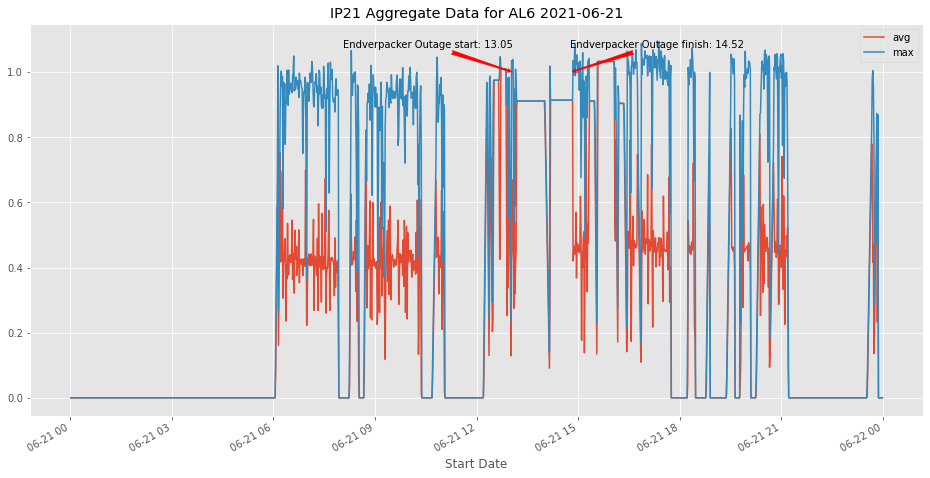

In [110]:
import matplotlib.pyplot as plt
df_IP21[['avg','max']][df_IP21.name == '36630901_S130HEIGHT_L9'].plot(figsize=(16,8), title='IP21 Aggregate Data for AL6 2021-06-21')
# plt.annotate(s='',Direction xy=('2021-06-21 13:05:00', 60), xytext=('2021-06-21 13:05:00', 0), arrowprops=dict(arrowstyle='<-<')
# plt.show())
plt.annotate('Endverpacker Outage start: 13.05', xy=('2021-06-21 13:05:00', 1),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Endverpacker Outage finish: 14.52', xy=('2021-06-21 14.51:46:00', 1),  xycoords='data',
            xytext=('2021-06-21 14.51:46:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            )       

In [111]:
df_IP21[df_IP21.name.str.contains('36630901_S130HEIGHT_L9')]

name  avg  min  max  std  sum
Start Date                                                          
2021-06-21 00:01:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-06-21 00:02:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-06-21 00:03:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-06-21 00:04:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-06-21 00:05:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
...                                     ...  ...  ...  ...  ...  ...
2021-06-21 23:55:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-06-21 23:56:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-06-21 23:57:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-06-21 23:58:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-06-21 23:59:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0

[1438 rows x 6 columns]

read in the HISTORY table csv which is built using this statement

```
for (select NAME, FIELD_ID, TS, PERIOD, REQUEST, STEPPED, VALUE, STATUS, SECONDS
 from history
where name like '366%'
  and ts between '21-Jun-21 00:00:00.0' and '21-Jun-21 23:59:59.9') do 
	write name || ',' || field_id || ',' || ts || ',' || period || ',' || request || ',' || stepped || ',' || value || ',' || status || ',' || seconds;
end
```


In [112]:
# read in txt file
file = (dir_sanofi_share + 'OEE data/IP21_AL6_History_20210621.txt')
df_IP21_hist = pd.read_csv(file, parse_dates=True, index_col='Timestamp', header=None, names=('name', 'field_id', 'Timestamp', 'period', 'request', 'stepped', 'value','status','seconds'))
df_IP21_hist.shape

(249120, 8)

In [113]:
df_IP21_hist.head()

name   field_id        period  request  \
Timestamp                                                                   
2021-06-21 00:00:00  36630901_CNTRB_ST6  605618176  +000:01:00.0        1   
2021-06-21 00:01:00  36630901_CNTRB_ST6  605618176  +000:01:00.0        1   
2021-06-21 00:02:00  36630901_CNTRB_ST6  605618176  +000:01:00.0        1   
2021-06-21 00:03:00  36630901_CNTRB_ST6  605618176  +000:01:00.0        1   
2021-06-21 00:04:00  36630901_CNTRB_ST6  605618176  +000:01:00.0        1   

                     stepped  value  status     seconds  
Timestamp                                                
2021-06-21 00:00:00        0    0.0       0  1624226400  
2021-06-21 00:01:00        0    0.0       0  1624226460  
2021-06-21 00:02:00        0    0.0       0  1624226520  
2021-06-21 00:03:00        0    0.0       0  1624226580  
2021-06-21 00:04:00        0    0.0       0  1624226640

Text(2021-06-21 14.51:46:00, 1.1, 'Endverpacker Outage finish: 14.52')

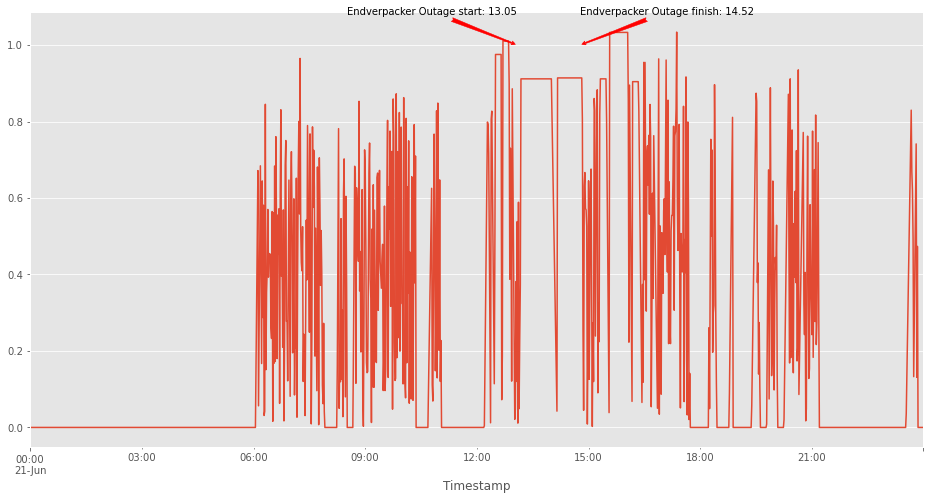

In [114]:
df_IP21_hist['value'][df_IP21_hist.name == '36630901_S130HEIGHT_L9'].plot(figsize=(16,8))

plt.annotate('Endverpacker Outage start: 13.05', xy=('2021-06-21 13:05:00', 1),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Endverpacker Outage finish: 14.52', xy=('2021-06-21 14.51:46:00', 1),  xycoords='data',
            xytext=('2021-06-21 14.51:46:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            )       

Identify all Endverpacker outages from looking at the QlikSense detailed events output

In [115]:
df_Endverpacker = pd.read_excel(dir_sanofi_share + 'OEE data/AL6_OEE_Detailed_Events_Endverpacker.xlsx', parse_dates=True, index_col='Start Date')

In [116]:
df_Endverpacker.head()

Shift Long Name            End Date  \
Start Date                                                            
2021-04-01 09:36:34  FRUE - 01/04/2021 06:00:00 2021-04-01 09:43:49   
2021-04-01 10:03:19  FRUE - 01/04/2021 06:00:00 2021-04-01 10:13:37   
2021-04-01 10:16:25  FRUE - 01/04/2021 06:00:00 2021-04-01 10:23:19   
2021-04-01 15:43:49  SPAE - 01/04/2021 14:00:00 2021-04-01 15:47:39   
2021-04-01 15:49:44  SPAE - 01/04/2021 14:00:00 2021-04-01 15:58:00   

                     Duration (min.)                  Stoppage Reason 3  \
Start Date                                                                
2021-04-01 09:36:34         7.250000  Störungen und Fehlerbehebung (25)   
2021-04-01 10:03:19        10.300000  Störungen und Fehlerbehebung (25)   
2021-04-01 10:16:25         6.900000  Störungen und Fehlerbehebung (25)   
2021-04-01 15:43:49         3.833333  Störungen und Fehlerbehebung (25)   
2021-04-01 15:49:44         8.266667  Störungen und Fehlerbehebung (25)   

                               Last Level Reason           Machine Comments  \
Start Date                                                                    
2021-04-01 09:36:34  Verklebestation (251270507)  AL6 Endverpacker        -   
2021-04-01 10:03:19    Stapeleinheit (251270502)  AL6 Endverpacker        -   
2021-04-01 10:16:25    Stapeleinheit (251270502)  AL6 Endverpacker        -   
2021-04-01 15:43:49  Verklebestation (251270507)  AL6 Endverpacker        -   
2021-04-01 15:49:44  Verklebestation (251270507)  AL6 Endverpacker        -   

                      Creator  
Start Date                     
2021-04-01 09:36:34  DE013273  
2021-04-01 10:03:19  DE013273  
2021-04-01 10:16:25  DE013273  
2021-04-01 15:43:49  DE017461  
2021-04-01 15:49:44  DE017461

In [117]:
outages = df_Endverpacker['Duration (min.)'].sum()
count = df_Endverpacker.count()

print ("Minutes lost to Endverpacker outages since 2021-04-01: {:,.2f} mins".format(outages))

Minutes lost to Endverpacker outages since 2021-04-01: 1,741.12 mins


In [118]:

df_Endverpacker.describe()

Duration (min.)
count       211.000000
mean          8.251738
std          13.598047
min           0.016667
25%           0.808333
50%           5.400000
75%           9.900000
max         106.766667

In [119]:
stats = df_Endverpacker['Duration (min.)'].groupby(pd.Grouper(freq='D')).describe().reset_index()



read in aggregates for Endverpacker which was extracted using this:

```
for (select name, ts, avg, min, max, std, sum from aggregates
where name = '36630901_S130HEIGHT_L9'
 and ts between '01-Jan-21 0:00:00.0' and '28-Jul-21 23:59:59.9') do
write name || ',' || ts || ',' || avg || ',' || min || ',' || max || ',' || std || ',' || sum;
end
```

In [120]:
# read in txt file
file = (dir_sanofi_share + 'OEE data/IP21_AL6_Aggregates_Endverpacker.txt')
df_IP21_agg_Endverpacker = pd.read_csv(file, parse_dates=True, index_col='Start Date', header=None, names=('name', 'Start Date', 'avg', 'min', 'max', 'std', 'sum'))
df_IP21_agg_Endverpacker.shape

(300899, 6)

In [121]:
df_IP21_agg_Endverpacker.head()

name  avg  min  max  std  sum
Start Date                                                          
2021-01-01 00:01:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-01-01 00:02:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-01-01 00:03:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-01-01 00:04:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0
2021-01-01 00:05:00  36630901_S130HEIGHT_L9  0.0  0.0  0.0  0.0  0.0

Do I need to get the dates of Endverpacker outages and then search for IP21 data, or find timestamps in IP21 that are near? 

In [122]:
Endverpacker_dates = df_Endverpacker.index.map(pd.Timestamp.date).unique()

In [123]:
df_Endverpacker_merge = pd.merge_asof(df_Endverpacker.sort_index(), df_IP21_agg_Endverpacker.sort_index(), left_index=True, right_index=True, allow_exact_matches=True, direction='forward')

Text(2021-06-21 13:05:00, 1.4, '2021-06-21')

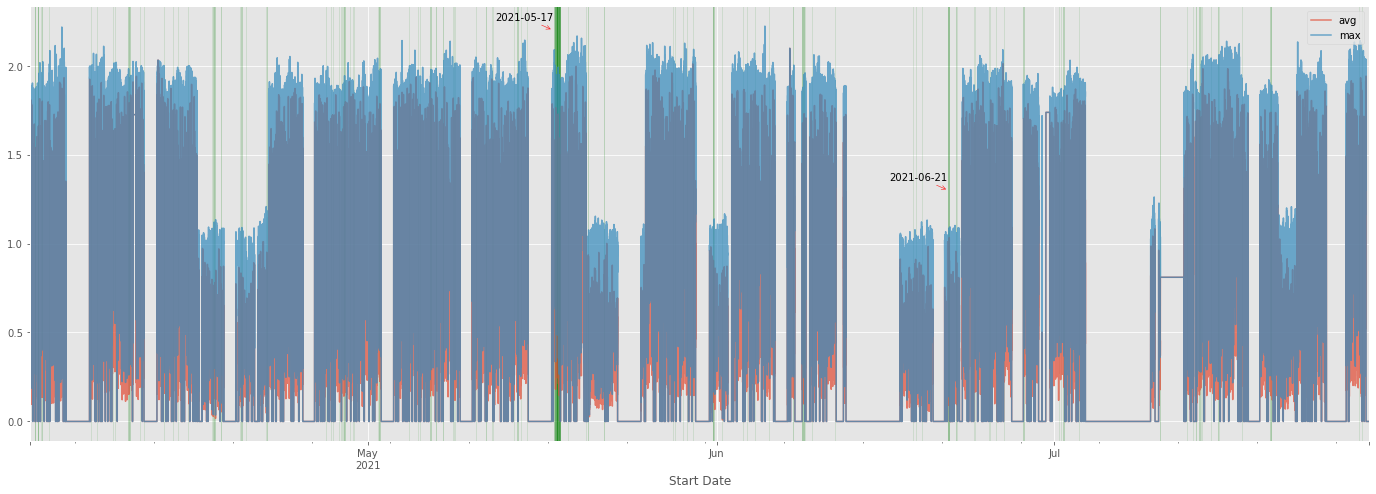

In [124]:
df_IP21_agg_Endverpacker[['avg','max']][df_IP21_agg_Endverpacker.index > start_date].plot(figsize=(24,8), alpha=0.7)
for i, row in df_Endverpacker_merge.iterrows():
    plt.axvspan(i, row[1], color='green', alpha=0.2)
plt.annotate('2021-05-17', xy=('2021-05-17 10.00:00:00', 2.2),  xycoords='data',
            xytext=('2021-05-17 12.00:00:00', 2.3),
            arrowprops=dict(arrowstyle="->", color='red'),
            horizontalalignment='right', verticalalignment='top',
            ) 
plt.annotate('2021-06-21', xy=('2021-06-21 13:05:00', 1.3),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.4),
            arrowprops=dict(arrowstyle="->", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )


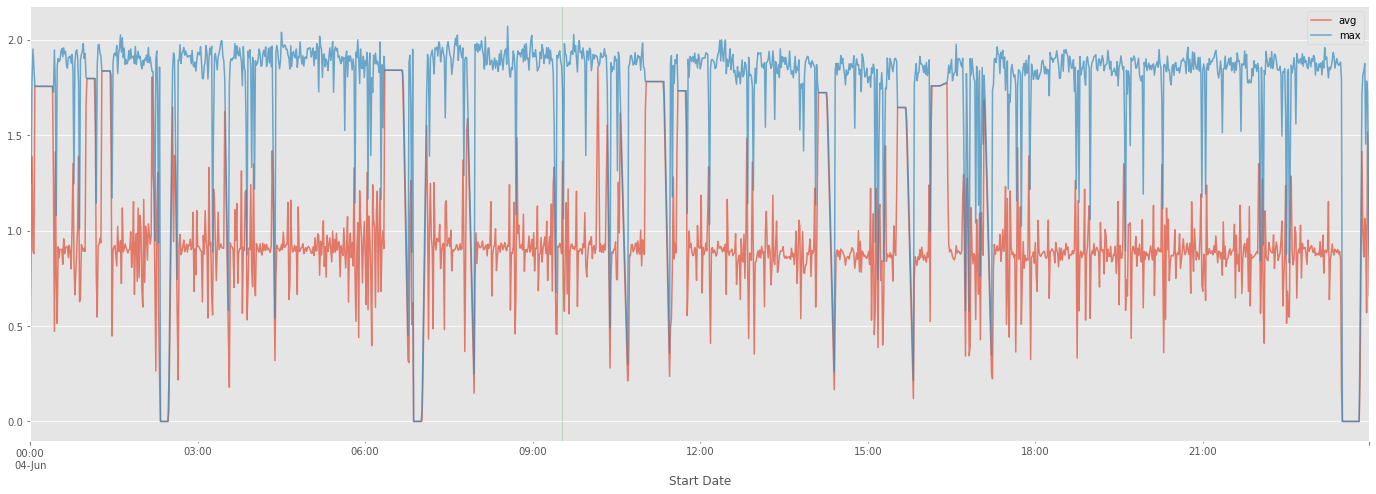

In [125]:
df_IP21_agg_Endverpacker[['avg','max']].loc['2021-06-04'].plot(figsize=(24,8), alpha=0.7)
for i, row in df_Endverpacker_merge.iterrows():
    plt.axvspan(i, row[1], color='green', alpha=0.4)

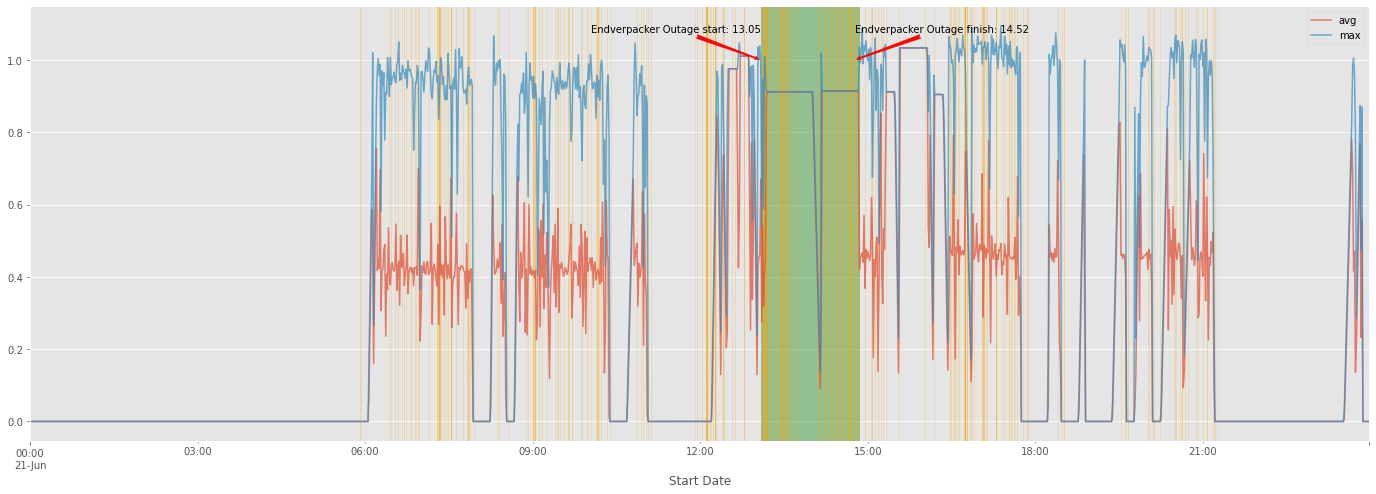

In [136]:
df_IP21_agg_Endverpacker[['avg','max']].loc['2021-06-21'].plot(figsize=(24,8), alpha=0.7)
for i, row in df_Endverpacker_merge.iterrows():
    plt.axvspan(i, row[1], color='green', alpha=0.2)
plt.annotate('Endverpacker Outage start: 13.05', xy=('2021-06-21 13:05:00', 1),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Endverpacker Outage finish: 14.52', xy=('2021-06-21 14.51:46:00', 1),  xycoords='data',
            xytext=('2021-06-21 14.51:46:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            ) 
for i, row in df_alarms.iterrows():
    plt.axvspan(i, i, color='orange', alpha=0.2)

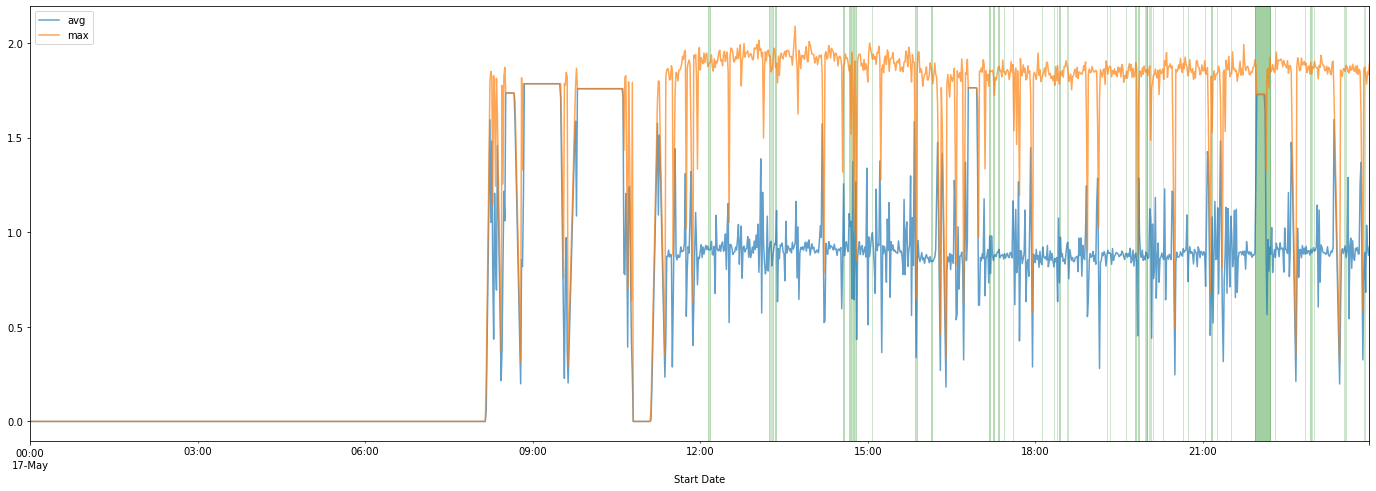

In [300]:
df_IP21_agg_Endverpacker[['avg','max']].loc['2021-05-17'].plot(figsize=(24,8), alpha=0.7)
for i, row in df_Endverpacker_merge.iterrows():
    plt.axvspan(i, row[1], color='green', alpha=0.2)

In [247]:
df_OEE[df_OEE.OEE == 100]

Category    OEE Month Day
Date                                                         
2021-07-04  Malfunctions and troubleshooting  100.0  July  04

In [313]:
df_OEE['dayofweek'] = df_OEE.index.to_series().dt.dayofweek

<AxesSubplot:xlabel='dayofweek'>

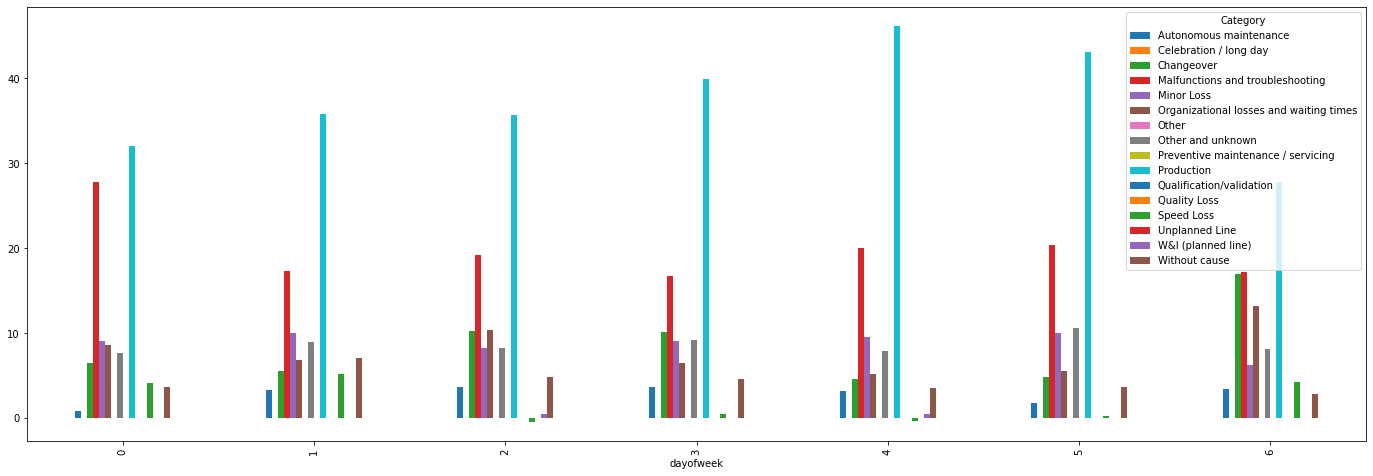

In [351]:
day = df_OEE.groupby(['Category','dayofweek']).mean().reset_index()
day.pivot(index='dayofweek', columns='Category', values='OEE').plot.bar(figsize=(24,8))

In [317]:
df_OEE

Category        OEE  Month Day  dayofweek
Date                                                                 
2021-04-01  Qualification/validation   0.000000  April  01          3
2021-04-01                Production  43.382099  April  01          3
2021-04-01                Minor Loss  12.870370  April  01          3
2021-04-01             Without cause   2.106481  April  01          3
2021-04-01         Other and unknown  10.745370  April  01          3
...                              ...        ...    ...  ..        ...
2021-07-19                     Other   0.000000   July  19          0
2021-07-19            Unplanned Line   0.000000   July  19          0
2021-07-19                Minor Loss   6.505450   July  19          0
2021-07-19        W&I (planned line)   0.000000   July  19          0
2021-07-19                Production  41.329095   July  19          0

[1384 rows x 5 columns]

# Get the alarms data

In [36]:
file = (dir_alarms + 'AL6_Endverpacker/20210621_Alarms.xlsx')
df_alarms = pd.read_excel(file, parse_dates=True, index_col='TimeIn')

In [38]:
df_alarms.MessageText.unique()

array(['Maschine startbereit', 'Maschine startet',
       'Maschine wartet auf Produkte', 'Roboter: Palette voll',
       'FTS: Maschine wartet auf Palettenabholung', 'Maschine hält an',
       'Schutztür 1 geöffnet', 'FTS: Maschine wartet auf Leerpaletten',
       'Palettenmagazin: Vorwarnung Palettenende',
       'Palettenmagazin: Paletten sind zu Ende',
       'Palettenmagazin: Lichtgitter ist unterbrochen',
       'Palettenmagazin: Lichtgitter quittieren',
       'Ausschleusvorrichtung: Karton wird ausgeschleust',
       'IPC Karton: Karton wurde ausgeschleust',
       'Zylinderkontrolle: Palettenübersetzer Lückenschließer an Palettenabschub öffnen',
       'Palette leerfahren ist angewählt',
       'Palettenaustransport 2: Sicherheitslichtschranke unterbrochen',
       'Sicherheitskreis der Türen unterbrochen',
       'Palettenaustransport 2: Frequenzumrichter',
       'Palettenaustransport 2: Sicherheitslichtschranke rücksetzen',
       'Kein Batch aktiv - Maschinenstart verriege

In [42]:
df_alarms.replace({
'Maschine startbereit':'Machine ready to start',
'Maschine startet':'Machine starts',
'Maschine wartet auf Produkte':'Machine is waiting for products',
'Roboter: Palette voll':'Robot: pallet full',
'FTS: Maschine wartet auf Palettenabholung':'AGV: machine is waiting for pallet pick-up',
'Maschine hält an':'Machine stops',
'Schutztür 1 geöffnet':'Protective door 1 open',
'FTS: Maschine wartet auf Leerpaletten':'AGV: machine is waiting for empty pallets',
'Palettenmagazin: Vorwarnung Palettenende':'Pallet magazine: prewarning pallet end',
'Palettenmagazin: Paletten sind zu Ende':'Pallet magazine: pallets have run out',
'Palettenmagazin: Lichtgitter ist unterbrochen':'Pallet magazine: light curtain is interrupted',
'Palettenmagazin: Lichtgitter quittieren':'Pallet magazine: acknowledge light curtain',
'Ausschleusvorrichtung: Karton wird ausgeschleust':'Ejection device: carton is ejected',
'IPC Karton: Karton wurde ausgeschleust':'IPC carton: carton was ejected',
'Zylinderkontrolle: Palettenübersetzer Lückenschließer an Palettenabschub öffnen':'Cylinder control: pallet translator open gap closer on pallet push-off',
'Palette leerfahren ist angewählt':'Empty pallet is selected',
'Palettenaustransport 2: Sicherheitslichtschranke unterbrochen':'Pallet outfeed 2: safety light barrier interrupted',
'Sicherheitskreis der Türen unterbrochen':'Safety circuit of the doors interrupted',
'Palettenaustransport 2: Frequenzumrichter':'Pallet transport 2: frequency converter',
'Palettenaustransport 2: Sicherheitslichtschranke rücksetzen':'Pallet outfeed 2: reset safety light barrier',
'Kein Batch aktiv - Maschinenstart verriegelt!':'No batch active - machine start locked!',
'Kamerasystem 3: ausgeschaltet':'Camera system 3: switched off',
'Kamerasystem 4: ausgeschaltet':'Camera system 4: switched off',
'Track & Trace System: Nicht betriebsbereit':'Track & Trace System: Not ready for operation',
'Schutztür 2 geöffnet':'Protective door 2 open',
'Kamerasystem 3: Kein "Gut" Signal':'Camera system 3: No "good" signal',
'Ausschleusvorrichtung: Ausschleusung Serienfehler Etikett':'Reject device: rejection of serial error label',
'Palettenmagazin: Sicherheitslichtschranke Muting Zeitüberlauf':'Pallet magazine: Muting safety light barrier time overflow',
'Ausschleusvorrichtung: Karton wurde nicht ausgeschleust':'Ejection device: carton was not ejected',
'Roboter: Karton verloren in Abholposition':'Robot: carton lost in pick-up position',
'Roboter: verlorener Karton in Abholposition entfernt?':'Robot: lost carton removed from pick-up position?'
}, inplace=True)

In [199]:
df_alarms.loc['2021-06-21'].groupby('MessageText')['MessageText'].count().sort_values(ascending=False)

MessageText
Machine is waiting for products                                           315
Camera system 3: No "good" signal                                          44
Machine ready to start                                                     44
Machine starts                                                             42
Machine stops                                                              42
AGV: machine is waiting for pallet pick-up                                 32
Track & Trace System: Not ready for operation                              28
Robot: pallet full                                                         24
Reject device: rejection of serial error label                             12
Protective door 1 open                                                     10
Protective door 2 open                                                      6
Pallet magazine: prewarning pallet end                                      6
Safety circuit of the doors interrupted             

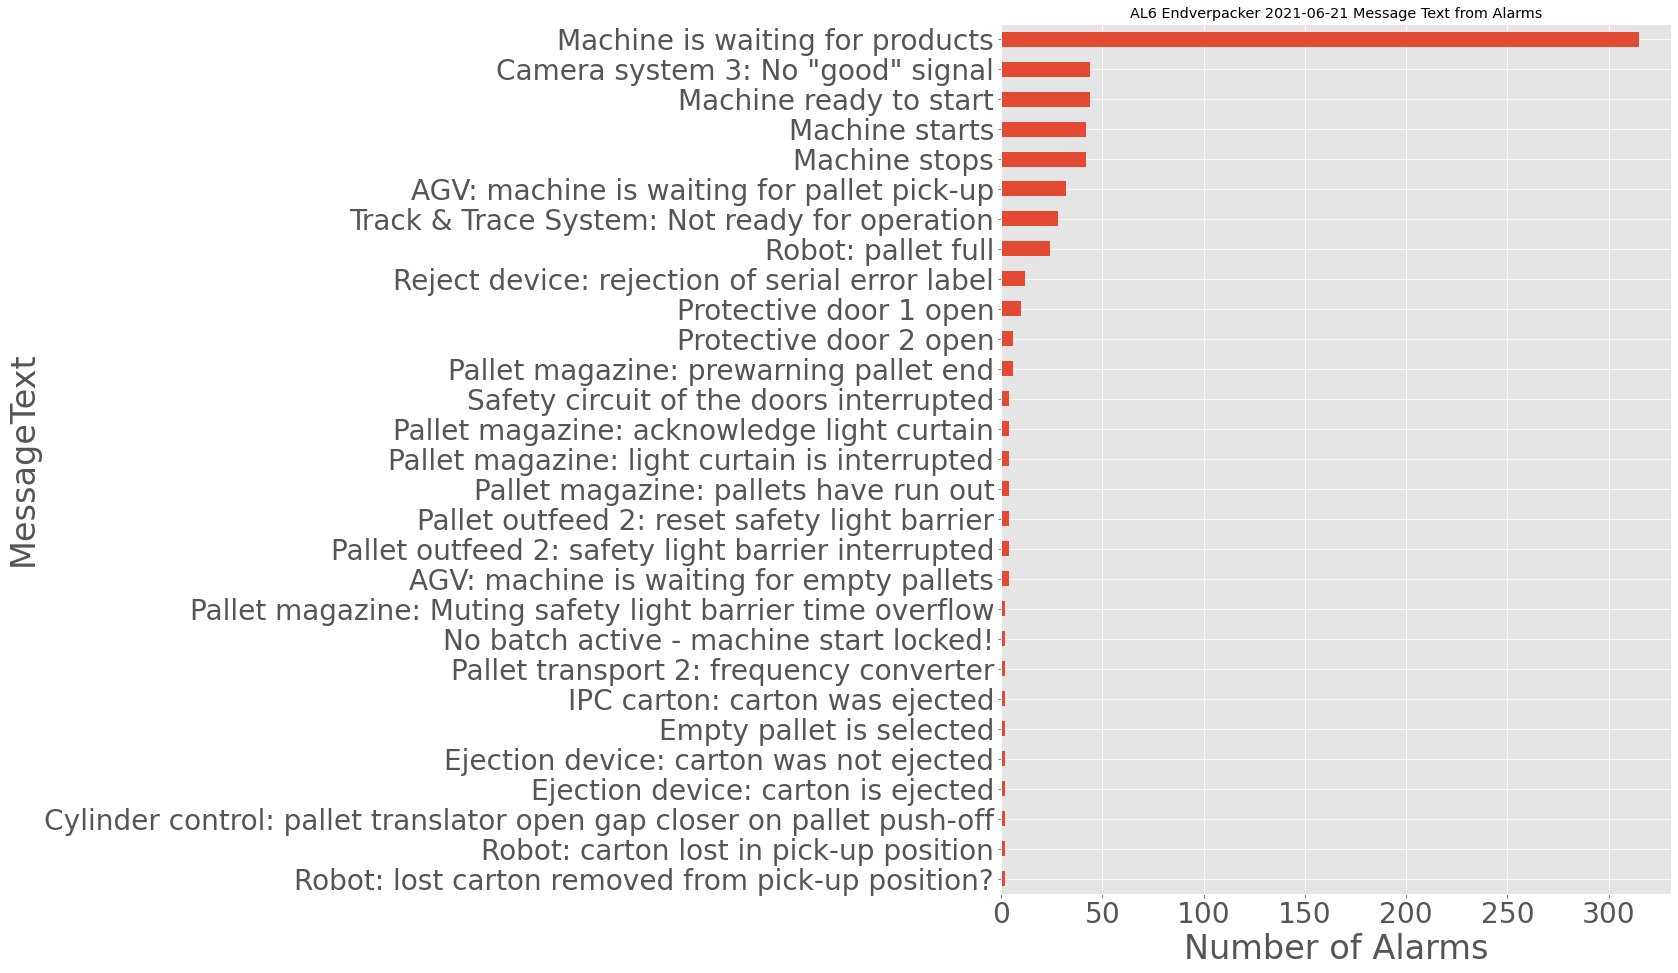

In [197]:
df_alarms.loc['2021-06-21'].groupby('MessageText')['MessageText'].count().sort_values(ascending=True).plot.barh(figsize=(12,16))
plt.style.use('ggplot')
plt.title('AL6 Endverpacker 2021-06-21 Message Text from Alarms')
plt.xlabel('Number of Alarms')
plt.rcParams.update({'font.size': 28})
plt.show()

In [182]:
df_alarms.to_excel(dir_sanofi_share + 'OEE data/AL6_Endverpacker_alarms.xlsx')

In [135]:
df_alarms.filter(regex='Time')

TimeUserAck                  TimePLCAck  \
TimeIn                                                            
2021-06-20 05:38:01.758    00:00:00  2021-06-21 05:54:53.422000   
2021-06-21 05:54:53.422    00:00:00                    00:00:00   
2021-06-21 05:54:53.422    00:00:00  2021-06-21 05:54:55.602000   
2021-06-21 05:55:15.615    00:00:00                    00:00:00   
2021-06-21 05:55:15.615    00:00:00  2021-06-21 06:22:34.969000   
...                             ...                         ...   
2021-06-21 21:12:45.295    00:00:00                    00:00:00   
2021-06-21 21:12:45.295    00:00:00  2021-06-21 21:12:46.286000   
2021-06-21 21:13:26.213    00:00:00                    00:00:00   
2021-06-21 21:13:26.213    00:00:00  2021-06-21 21:14:43.749000   
2021-06-21 21:15:23.687    00:00:00                    00:00:00   

                                  TimeInUTC  
TimeIn                                       
2021-06-20 05:38:01.758 2021-06-20 03:38:02  
2021-06-21 05:54:53.422 2021-06-21 03:54:53  
2021-06-21 05:54:53.422 2021-06-21 03:54:53  
2021-06-21 05:55:15.615 2021-06-21 03:55:16  
2021-06-21 05:55:15.615 2021-06-21 03:55:16  
...                                     ...  
2021-06-21 21:12:45.295 2021-06-21 19:12:45  
2021-06-21 21:12:45.295 2021-06-21 19:12:45  
2021-06-21 21:13:26.213 2021-06-21 19:13:26  
2021-06-21 21:13:26.213 2021-06-21 19:13:26  
2021-06-21 21:15:23.687 2021-06-21 19:15:24  

[657 rows x 3 columns]

In [140]:
df_alarms.filter(regex='Time')



TimeUserAck                  TimePLCAck  \
TimeIn                                                            
2021-06-20 05:38:01.758    00:00:00  2021-06-21 05:54:53.422000   
2021-06-21 05:54:53.422    00:00:00                    00:00:00   
2021-06-21 05:54:53.422    00:00:00  2021-06-21 05:54:55.602000   
2021-06-21 05:55:15.615    00:00:00                    00:00:00   
2021-06-21 05:55:15.615    00:00:00  2021-06-21 06:22:34.969000   
...                             ...                         ...   
2021-06-21 21:12:45.295    00:00:00                    00:00:00   
2021-06-21 21:12:45.295    00:00:00  2021-06-21 21:12:46.286000   
2021-06-21 21:13:26.213    00:00:00                    00:00:00   
2021-06-21 21:13:26.213    00:00:00  2021-06-21 21:14:43.749000   
2021-06-21 21:15:23.687    00:00:00                    00:00:00   

                                  TimeInUTC  
TimeIn                                       
2021-06-20 05:38:01.758 2021-06-20 03:38:02  
2021-06-21 05:54:53.422 2021-06-21 03:54:53  
2021-06-21 05:54:53.422 2021-06-21 03:54:53  
2021-06-21 05:55:15.615 2021-06-21 03:55:16  
2021-06-21 05:55:15.615 2021-06-21 03:55:16  
...                                     ...  
2021-06-21 21:12:45.295 2021-06-21 19:12:45  
2021-06-21 21:12:45.295 2021-06-21 19:12:45  
2021-06-21 21:13:26.213 2021-06-21 19:13:26  
2021-06-21 21:13:26.213 2021-06-21 19:13:26  
2021-06-21 21:15:23.687 2021-06-21 19:15:24  

[657 rows x 3 columns]

In [184]:
df_alarms[df_alarms['MessageText'].str.contains('Camera')].loc['2021-06-21']

ID  State StateID StateText TimeUserAck  \
TimeIn                                                              
2021-06-21 13:06:57.746  917      4   $2522       MGK    00:00:00   
2021-06-21 13:06:57.746  917      0   $2524       MGG    00:00:00   
2021-06-21 13:08:24.092  917      4   $2522       MGK    00:00:00   
2021-06-21 13:08:24.092  917      0   $2524       MGG    00:00:00   
2021-06-21 13:09:28.422  917      4   $2522       MGK    00:00:00   
2021-06-21 13:09:28.422  917      0   $2524       MGG    00:00:00   
2021-06-21 13:11:44.716  917      4   $2522       MGK    00:00:00   
2021-06-21 13:11:44.716  917      0   $2524       MGG    00:00:00   
2021-06-21 13:12:37.743  917      4   $2522       MGK    00:00:00   
2021-06-21 13:12:37.743  917      0   $2524       MGG    00:00:00   
2021-06-21 13:19:40.997  917      4   $2522       MGK    00:00:00   
2021-06-21 13:19:40.997  917      0   $2524       MGG    00:00:00   
2021-06-21 13:23:38.076  917      4   $2522       MGK    00:00:00   
2021-06-21 13:23:38.076  917      0   $2524       MGG    00:00:00   
2021-06-21 13:26:02.102  917      4   $2522       MGK    00:00:00   
2021-06-21 13:26:02.102  917      0   $2524       MGG    00:00:00   
2021-06-21 13:27:59.550  917      4   $2522       MGK    00:00:00   
2021-06-21 13:27:59.550  917      0   $2524       MGG    00:00:00   
2021-06-21 13:31:43.384  917      4   $2522       MGK    00:00:00   
2021-06-21 13:31:43.384  917      0   $2524       MGG    00:00:00   
2021-06-21 13:33:08.706  917      4   $2522       MGK    00:00:00   
2021-06-21 13:33:08.706  917      0   $2524       MGG    00:00:00   
2021-06-21 13:43:27.037  917      4   $2522       MGK    00:00:00   
2021-06-21 13:43:27.037  917      0   $2524       MGG    00:00:00   
2021-06-21 14:06:57.400  917      4   $2522       MGK    00:00:00   
2021-06-21 14:06:57.400  917      0   $2524       MGG    00:00:00   
2021-06-21 14:15:08.428  917      4   $2522       MGK    00:00:00   
2021-06-21 14:15:08.428  917      0   $2524       MGG    00:00:00   
2021-06-21 14:22:17.393  917      4   $2522       MGK    00:00:00   
2021-06-21 14:22:17.393  917      0   $2524       MGG    00:00:00   
2021-06-21 14:29:06.480  917      4   $2522       MGK    00:00:00   
2021-06-21 14:29:06.480  917      0   $2524       MGG    00:00:00   
2021-06-21 14:32:01.558  917      4   $2522       MGK    00:00:00   
2021-06-21 14:32:01.558  917      0   $2524       MGG    00:00:00   
2021-06-21 15:04:55.571  917      4   $2522       MGK    00:00:00   
2021-06-21 15:04:55.571  917      0   $2524       MGG    00:00:00   
2021-06-21 16:28:17.375  917      4   $2522       MGK    00:00:00   
2021-06-21 16:28:17.375  917      0   $2524       MGG    00:00:00   
2021-06-21 16:32:13.382  917      4   $2522       MGK    00:00:00   
2021-06-21 16:32:13.382  917      0   $2524       MGG    00:00:00   
2021-06-21 16:38:02.295  917      4   $2522       MGK    00:00:00   
2021-06-21 16:38:02.295  917      0   $2524       MGG    00:00:00   
2021-06-21 16:45:15.597  917      4   $2522       MGK    00:00:00   
2021-06-21 16:45:15.597  917      0   $2524       MGG    00:00:00   

                                         TimePLCAck MessageID  \
TimeIn                                                          
2021-06-21 13:06:57.746                    00:00:00     $9686   
2021-06-21 13:06:57.746  2021-06-21 13:06:59.956000     $9686   
2021-06-21 13:08:24.092                    00:00:00     $9686   
2021-06-21 13:08:24.092  2021-06-21 13:08:26.251000     $9686   
2021-06-21 13:09:28.422                    00:00:00     $9686   
2021-06-21 13:09:28.422  2021-06-21 13:09:29.412000     $9686   
2021-06-21 13:11:44.716                    00:00:00     $9686   
2021-06-21 13:11:44.716  2021-06-21 13:11:46.804000     $9686   
2021-06-21 13:12:37.743                    00:00:00     $9686   
2021-06-21 13:12:37.743  2021-06-21 13:12:38.835000     $9686   
2021-06-21 13:19:40.997                    00:00:00     $9686   
2021-0